# 利潤模型
透過利潤模型決定較佳的機器學習模型作為選擇

## 一、前置作業

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Mac XGBoost
import util
from util import get_dummies, detect_str_columns,model_testRF,results_summary_to_dataframe,plot_confusion_matrix,logistic_model,logistic_importance,logistic_conf,model_profit_fun,model_profit_newdata_fun
from util import profit_linechart, profit_linechart_all
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, accuracy_score,classification_report
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import shutil

# ----設定繪圖-------
import matplotlib.pyplot as plt
import seaborn as sns

【注意要點】

【資料格式要點】：
資料格式為每一筆（row）記載的資料是by 會員（如：UID）

【資料蒐集要點】

X：
 - 行為變數：記載或轉換資料集成每一位會員接受到的行銷或服務狀況（如：使用時間...）
 - 人口變數：男女、年齡分組等 --> 若為字串要轉換one-hot encoding
 - 順序變數：滿意、不滿意等，具順序性的變數要轉換成label encoding，以數字大小標示

y：是否購買 or 是否KPI（分類）

【分析】
商業上，通常使用LogisticRegression當做是我們的baseline，
而XGBoost與Random Forest通常會以非線性的評估方法勝出
建議以「獲利為主」的評估方式為恰當

【適用】
適用消費者是否購買之資料集 --> 分類之概念
適用要將資料集自行切分為training set與Testing set的實作

【資料集說明】
1. data --> training set與Testing set
2. training set --> analysis --> testing set


In [2]:
data = pd.read_csv('contract.csv')
data.head()

,Prod_output_num,locations,gender,age,click_on_prod,balance,registry_to_use_time,credit_card_paid,active_member,estimated_salary,buy,UID
0,619,Taipei,Female,42,2,0.00,4,1,0,101348.88,1,0
1,608,Tainan,Female,41,1,83807.86,4,0,0,112542.58,0,1
2,502,Taipei,Female,42,8,159660.80,2,1,1,113931.57,1,2
3,699,Taipei,Female,39,1,0.00,3,0,1,93826.63,0,3
4,850,Tainan,Female,43,2,125510.82,4,1,0,79084.10,0,4


In [3]:
# 資料前處理
str_columns = detect_str_columns(data)
dataset = get_dummies(str_columns, data)
X =dataset.drop(columns=['buy'])
y =dataset['buy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
train_uid = X_train['UID']
test_uid = X_test['UID']
del X_train['UID']
del X_test['UID']

## 二、背景說明

- 售價 = 3500
- 行銷成本 = 300
- 產品成本 = 1650

## 三、Logistic Regression 利潤評估模型

################ summary ################ 
[[1553   42]
 [ 380   25]]
Training Accuracy = 0.790
Test Accuracy = 0.789
------------------模型相對權市場行銷來說【賠錢】------------------
模型比全市場行銷損失 $-123100
比較全市場行銷來說，淨利減少0.175倍
------------------全市場行銷利潤矩陣------------------
       項目    金額  目標對象       小計
0    單品價格  3500   405  1417500
1  單品營業成本  1650   405   668250
2  單品行銷費用   300  2000   600000
3      利潤     -     -   149250
全市場行銷利潤矩陣.csv saved
------------------LogisticRegression模型行銷利潤矩陣------------------
       項目    金額 目標對象     小計
0    單品價格  3500   25  87500
1  單品營業成本  1650   25  41250
2  單品行銷費用   300   67  20100
3      利潤     -    -  26150
模型行銷利潤矩陣.csv saved


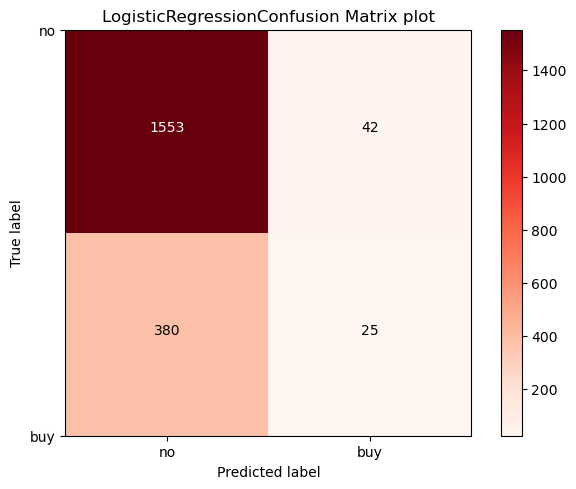

In [4]:
LR_all_df, LR_model_profit_df, LR_y_test_df = model_profit_fun(
        clf = LogisticRegression(), # sklearn的模型
        X_train=X_train, # 訓練資料集 X：training set (x)
        y_train=y_train, # 訓練資料集 Y：training set (buy)
        X_test=X_test, # 測試資料集 X : testing set (x)
        y_test=y_test, # 測試資料集 Y : testing set (buy)
        sales_price = 3500, # 價格
        marketing_expense = 300, # 行銷成本
        product_cost = 1650, # 產品成本
        plot_name = 'LogisticRegression') # 產出結果的名稱，會存到資料夾

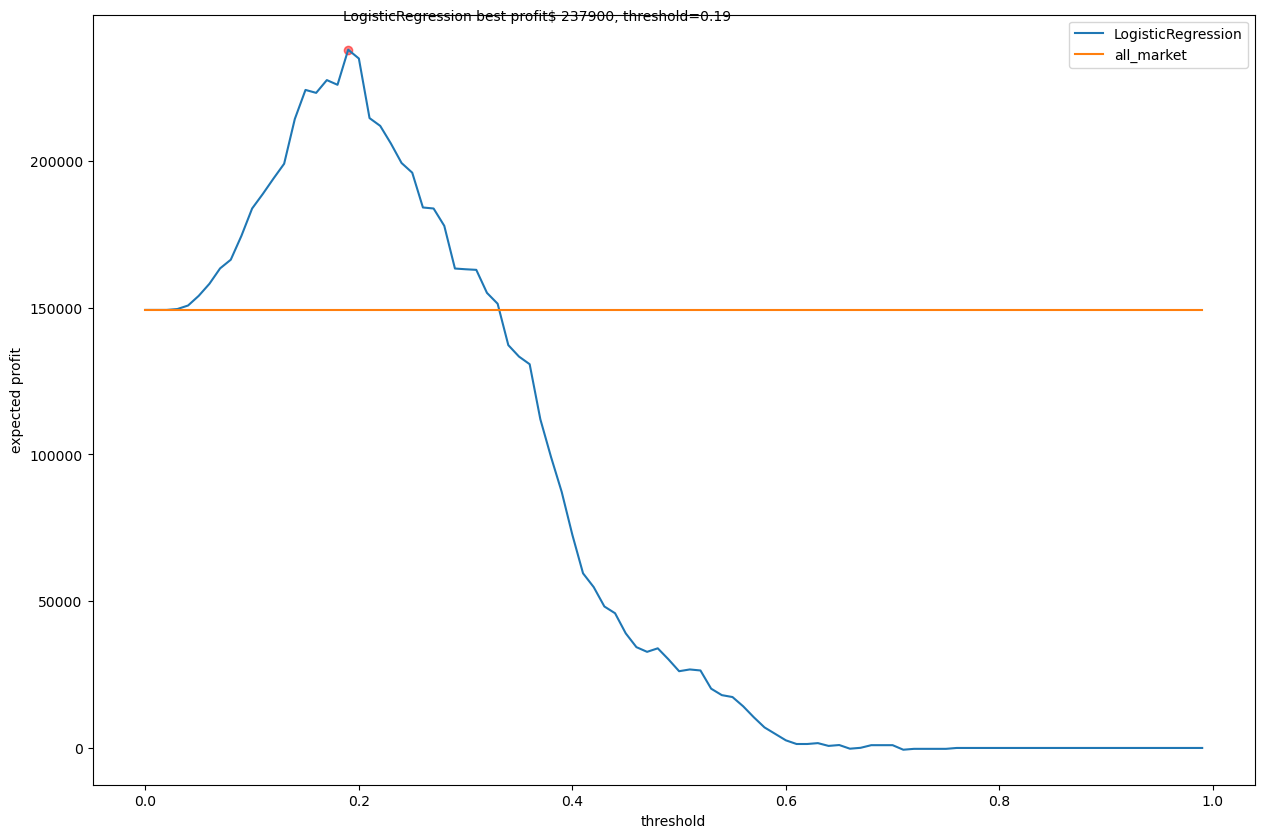

(19    0.19
 Name: 閥值, dtype: float64,
 237900)

In [5]:
#  畫出單一利潤折線圖
profit_linechart(
        y_test_df=LR_y_test_df,
                sales_price = 3500,
                marketing_expense = 300,
                product_cost = 1650,
                plot_name = 'LogisticRegression')

In [6]:
# 歸納檔案
from util import move_file
move_file(dectect_name = 'LogisticRegression', folder_name = 'LogisticRegression_利潤結果')

## 四、XGB 利潤評估模型

- XGBClassifier(n_estimators=300 ,random_state = 0,nthread = 8)
- plot_name = 'Random_Forest'
- RF_all_df : 全市場利潤表
- RF_model_profit_df : 預測模型利潤表
- RF_y_test_df ：顧客產品推薦名單

################ summary ################ 
[[1488  107]
 [ 192  213]]
Training Accuracy = 0.998
Test Accuracy = 0.851
------------------模型相對全市場行銷來說【賺錢】------------------
模型比全市場行銷賺 $148800
------------------全市場行銷利潤矩陣------------------
       項目    金額  目標對象       小計
0    單品價格  3500   405  1417500
1  單品營業成本  1650   405   668250
2  單品行銷費用   300  2000   600000
3      利潤     -     -   149250
全市場行銷利潤矩陣.csv saved
------------------XGB模型行銷利潤矩陣------------------
       項目    金額 目標對象      小計
0    單品價格  3500  213  745500
1  單品營業成本  1650  213  351450
2  單品行銷費用   300  320   96000
3      利潤     -    -  298050
模型行銷利潤矩陣.csv saved


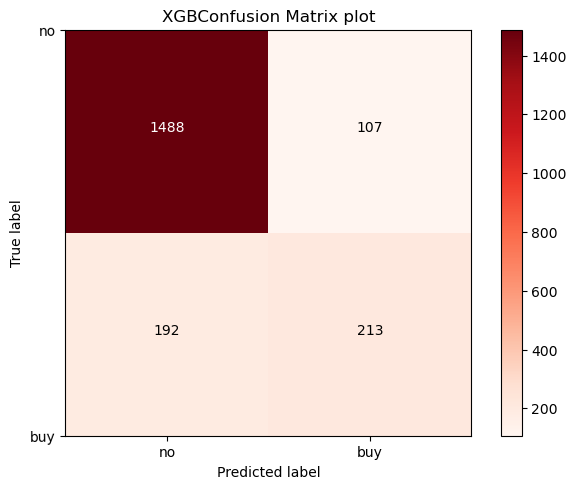

In [7]:
XGB_all_df, XGB_model_profit_df, XGB_y_test_df = model_profit_fun(

        clf =  XGBClassifier(n_estimators=300 ,random_state = 0,nthread = 8)   , # sklearn的模型
        X_train=X_train, # 訓練資料集 X：training set (x)
        y_train=y_train, # 訓練資料集 Y：training set (buy)
        X_test=X_test, # 測試資料集 X : testing set (x)
        y_test=y_test, # 測試資料集 Y : testing set (buy)
        sales_price = 3500, # 價格
        marketing_expense = 300, # 行銷成本
        product_cost = 1650, # 產品成本
        plot_name = 'XGB' ) # 產出結果的名稱，會存到資料夾


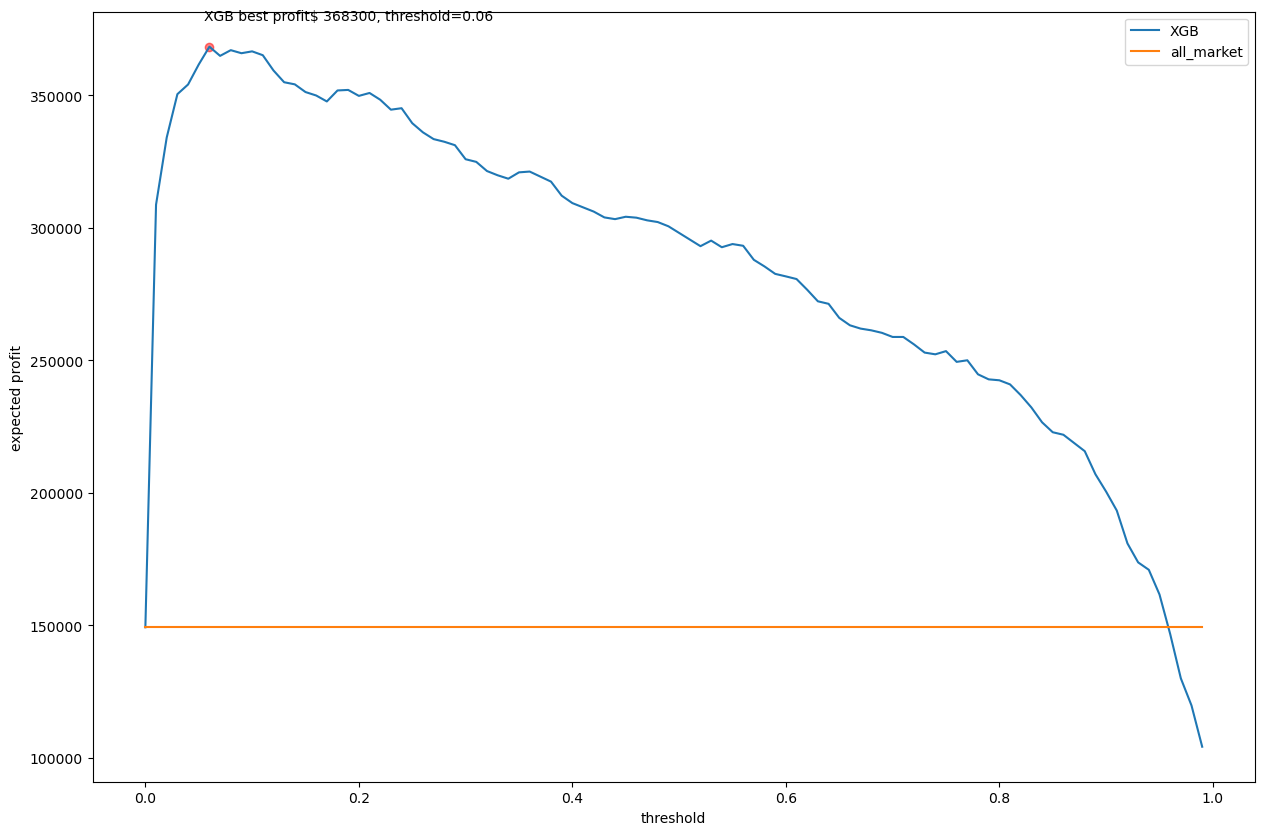

(6    0.06
 Name: 閥值, dtype: float64,
 368300)

In [8]:
# 畫出單一利潤折線圖
profit_linechart(
        y_test_df=XGB_y_test_df,
                sales_price = 3500,
                marketing_expense = 300,
                product_cost = 1650,
                plot_name = 'XGB')

In [9]:
# 歸納檔案
move_file(dectect_name = 'XGB', folder_name = 'XGB_利潤結果')

## 五、RF 利潤評估模型

- RandomForestClassifier(n_estimators = 100, random_state = 0)
- plot_name = 'Random_Forest'
- RF_all_df : 全市場利潤表
- RF_model_profit_df : 預測模型利潤表
- RF_y_test_df ：顧客產品推薦名單

################ summary ################ 
[[1528   67]
 [ 197  208]]
Training Accuracy = 1.000
Test Accuracy = 0.868
------------------模型相對全市場行銷來說【賺錢】------------------
模型比全市場行銷賺 $153050
------------------全市場行銷利潤矩陣------------------
       項目    金額  目標對象       小計
0    單品價格  3500   405  1417500
1  單品營業成本  1650   405   668250
2  單品行銷費用   300  2000   600000
3      利潤     -     -   149250
全市場行銷利潤矩陣.csv saved
------------------Random_Forest模型行銷利潤矩陣------------------
       項目    金額 目標對象      小計
0    單品價格  3500  208  728000
1  單品營業成本  1650  208  343200
2  單品行銷費用   300  275   82500
3      利潤     -    -  302300
模型行銷利潤矩陣.csv saved


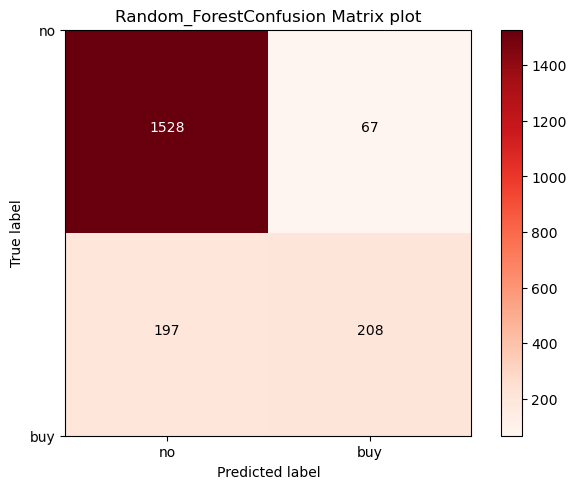

In [10]:
RF_all_df, RF_model_profit_df, RF_y_test_df = model_profit_fun(

        clf = RandomForestClassifier(n_estimators = 100, random_state = 0), # sklearn的模型
        X_train=X_train, # 訓練資料集 X：training set (x)
        y_train=y_train, # 訓練資料集 Y：training set (buy)
        X_test=X_test, # 測試資料集 X : testing set (x)
        y_test=y_test, # 測試資料集 Y : testing set (buy)
        sales_price = 3500, # 價格
        marketing_expense = 300, # 行銷成本
        product_cost = 1650, # 產品成本
        plot_name = 'Random_Forest' ) # 產出結果的名稱，會存到資料夾

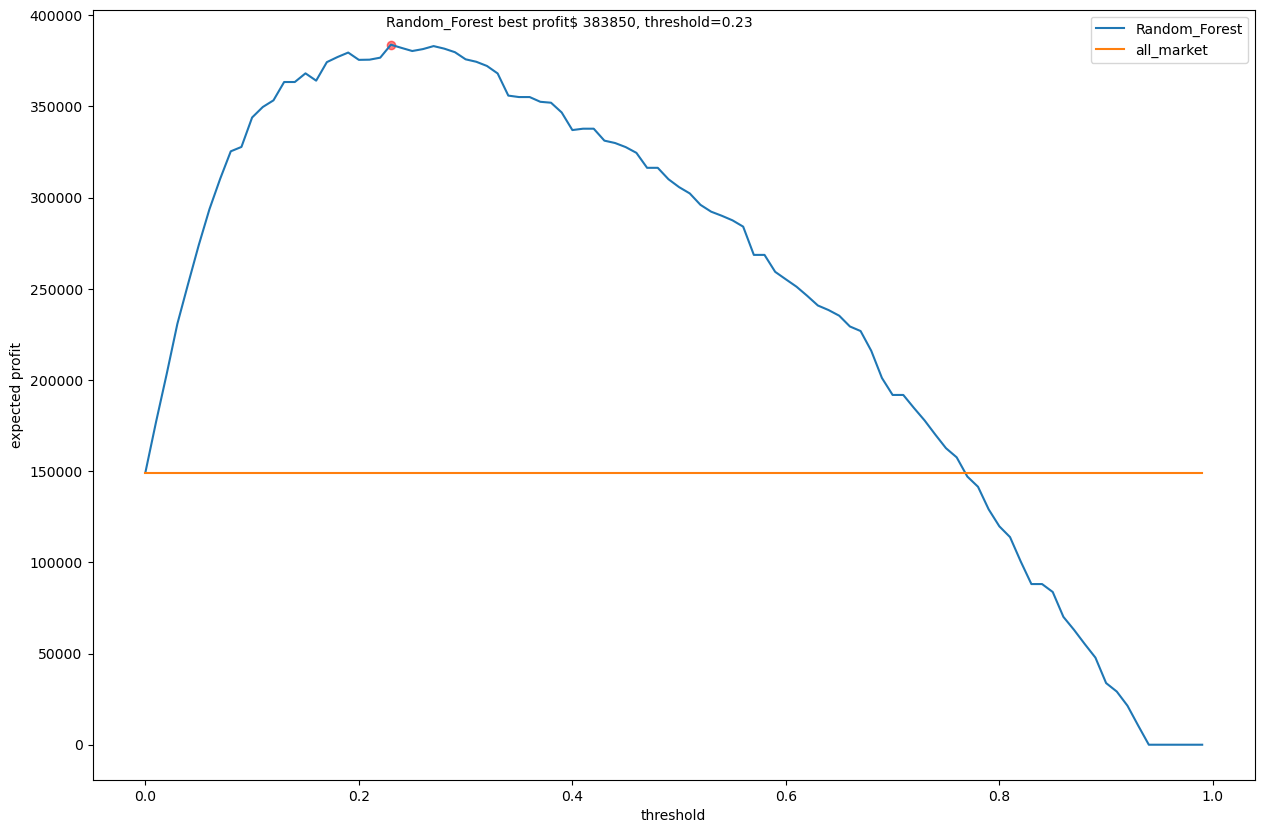

(23    0.23
 Name: 閥值, dtype: float64,
 383850)

In [11]:
# 單一利潤折線圖
profit_linechart(
        y_test_df= RF_y_test_df,
                sales_price = 3500,
                marketing_expense = 300,
                product_cost = 1650,
                plot_name = 'Random_Forest')

In [12]:
# 歸納檔案
move_file(dectect_name = 'Random_Forest', folder_name = 'RF_利潤結果')

## 六、利潤評估模型實作 － 多重評估法

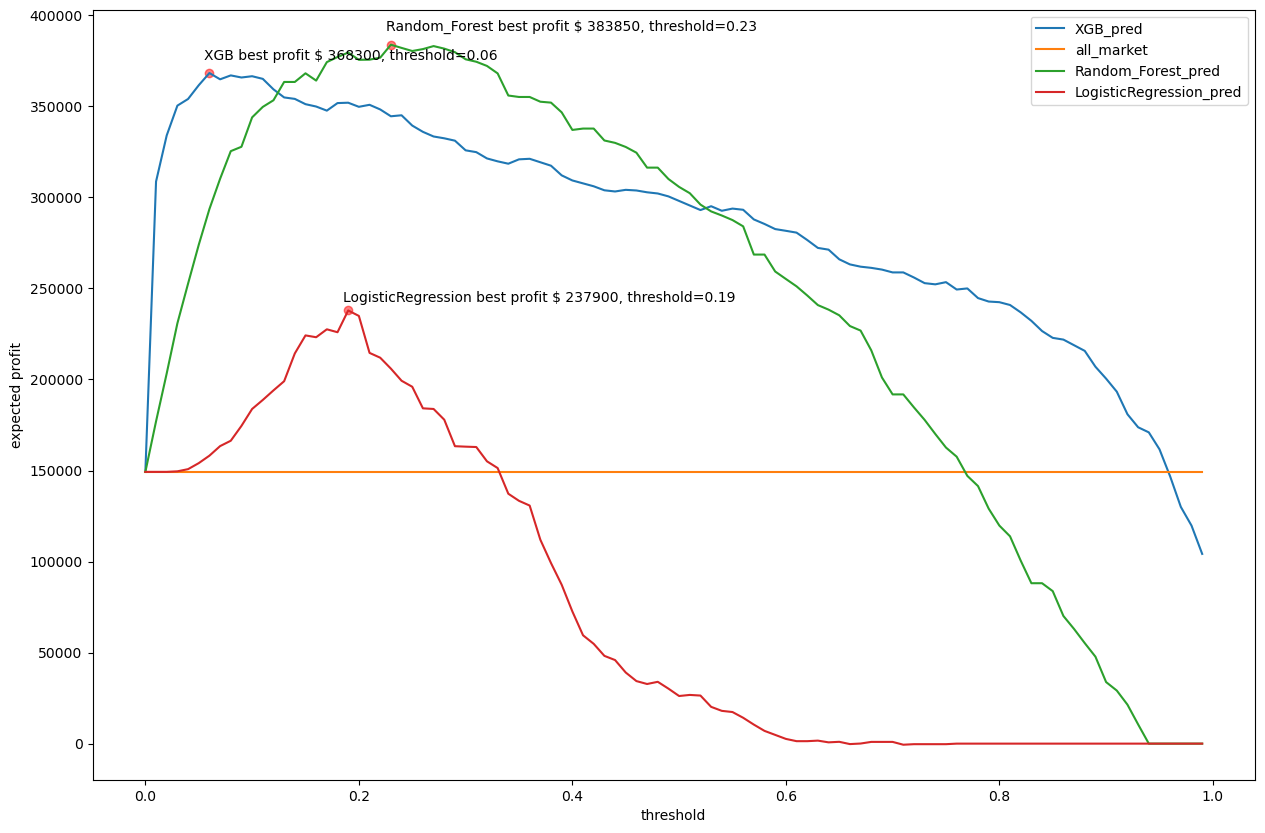

In [13]:
profit_linechart_all(y_test_df= [XGB_y_test_df,
                                RF_y_test_df,
                                LR_y_test_df] ,
                    sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1650)

In [14]:
from util import profit_linechart_all_web

profit_linechart_all_web(y_test_df= [XGB_y_test_df,
                                RF_y_test_df,
                                LR_y_test_df] ,
                    sales_price = 3500,
                    marketing_expense = 300,
                    product_cost = 1650,
                    plot_name_main= '預期獲利最佳化折線圖'
                    )